In [1]:
################################################################################
## Code adapted from demo_caiman_cnmf_3D as imported from github 21/11/2018
## https://github.com/flatironinstitute/CaImAn
################################################################################

import cde_cell_functions as cc

# Import relevant packages
#===============================================================================
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
import shutil
from scipy.ndimage.filters import gaussian_filter
import scipy.sparse
import sys
import re
from skimage.external.tifffile import imread
from skimage import io
import warnings 

# Caiman setup
#-------------------------------------------------------------------------------
import caiman as cm
import caiman.source_extraction.cnmf as cnmf
from caiman.utils.visualization import nb_view_patches3d
from caiman.source_extraction.cnmf import params as params
from caiman.components_evaluation import evaluate_components, estimate_components_quality_auto
from caiman.motion_correction import MotionCorrect
from caiman.cluster import setup_cluster
from caiman.paths import caiman_datadir
from caiman.utils.visualization import inspect_correlation_pnr

# Jupyter specific autoreloading for external functions (in case changes are made)
%load_ext autoreload
%autoreload 2

In [2]:
# Housekeeping
#===============================================================================
# Module flags

display_movie   = False      # play movie of tifs that are loaded
save_results    = False      # flag to save results or not

# Define folder locations
#-------------------------------------------------------------------------------
Fbase     = '/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy'
Fscripts  = Fbase + os.sep + '03 - Cell detection' 
Fdata     = '/Volumes/MARIANNE/1812 Critical Dynamics in Epilepsy'
Zfish     = cc.cde_cell_fishspec(Fdata, 'RM')

In [3]:
len(Zfish)

2

In [ ]:
cc.cde_cell_planesave(Fdata, Zfish[0])

I found 2 Conditions
Condition BL
> There are 9 Planes
> Processing plane 1
> > 0
> > 1000
> > 2000
> > 3000
> > 4000
> > 5000
> > 6000
> > 7000
> > > Saving interim file
> Processing plane 2
> > 0
> > 1000
> > 2000
> > 3000
> > 4000
> > 5000
> > 6000
> > 7000
> > > Saving interim file
> Processing plane 3
> > 0
> > 1000
> > 2000
> > 3000
> > 4000
> > 5000
> > 6000
> > 7000
> > > Saving interim file
> Processing plane 4
> > 0
> > 1000
> > 2000
> > 3000
> > 4000
> > 5000
> > 6000
> > 7000
> > > Saving interim file
> Processing plane 5
> > 0
> > 1000
> > 2000
> > 3000
> > 4000
> > 5000
> > 6000
> > 7000
> > > Saving interim file
> Processing plane 6
> > 0
> > 1000
> > 2000
> > 3000
> > 4000
> > 5000
> > 6000
> > 7000
> > > Saving interim file
> Processing plane 7
> > 0
> > 1000
> > 2000
> > 3000
> > 4000
> > 5000
> > 6000
> > 7000
> > > Saving interim file
> Processing plane 8
> > 0
> > 1000
> > 2000
> > 3000
> > 4000
> > 5000
> > 6000
> > 7000
> > > Saving interim file
> Processing plan

In [230]:
t = list(range(0,9000,8000))
t.append(9000)
t

In [ ]:
## fr = 15                                                             # frame rate (Hz)
decay_time = 0.5                                                    # approximate length of transient event in seconds
gSig = (4,4)                                                        # expected half size of neurons
p = 1                                                               # order of AR indicator dynamics
min_SNR = 1                                                         # minimum SNR for accepting new components
rval_thr = 0.90                                                     # correlation threshold for new component inclusion
ds_factor = 1                                                       # spatial downsampling factor (increases speed but may lose some fine structure)
gnb = 2                                                             # number of background components
gSig = tuple(np.ceil(np.array(gSig)/ds_factor).astype('int'))       # recompute gSig if downsampling is involved
mot_corr = True                                                     # flag for online motion correction 
pw_rigid = False                                                    # flag for pw-rigid motion correction (slower but potentially more accurate)
max_shifts_online = np.ceil(10./ds_factor).astype('int')            # maximum allowed shift during motion correction
sniper_mode = True                                                  # flag using a CNN to detect new neurons (o/w space correlation is used)
init_batch = 200                                                    # number of frames for initialization (presumably from the first file)
expected_comps = 500                                                # maximum number of expected components used for memory pre-allocation (exaggerate here)
dist_shape_update = True                                            # flag for updating shapes in a distributed way
min_num_trial = 10                                                  # number of candidate components per frame     
K = 2                                                               # initial number of components
epochs = 2                                                          # number of passes over the data
show_movie = False                                                  # show the movie with the results as the data gets processed

params_dict = {'fnames': fname,
               'fr': fr,
               'decay_time': decay_time,
               'gSig': gSig,
               'p': p,
               'min_SNR': min_SNR,
               'rval_thr': rval_thr,
               'ds_factor': ds_factor,
               'nb': gnb,
               'motion_correct': mot_corr,
               'init_batch': init_batch,
               'init_method': 'bare',
               'normalize': True,
               'expected_comps': expected_comps,
               'sniper_mode': sniper_mode,
               'dist_shape_update' : dist_shape_update,
               'min_num_trial': min_num_trial,
               'K': K,
               'epochs': epochs,
               'max_shifts_online': max_shifts_online,
               'pw_rigid': pw_rigid,
               'show_movie': show_movie}
opts = cnmf.params.CNMFParams(params_dict=params_dict)

In [38]:
cnm = cnmf.online_cnmf.OnACID(params=opts)
cnm.fit_online()

Size frame:(60, 80)
Noise Normalization
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING TOTAL SUM FOR INITIALIZATION....


/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/caiman/source_extraction/cnmf/initialization.py:635: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[[slice(*a) for a in ijSig]].copy(), dtype=np.float32)
/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/caiman/source_extraction/cnmf/initialization.py:650: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[[slice(*a) for a in ijSig]] -= dataSig.copy()
/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/caiman/source_extraction/cnmf/initialization.py:657: FutureWarning: Usi

(Hals) Refining Components...
Expecting 500 components


Using TensorFlow backend.


Now processing file /Users/roschkoenig/caiman_data/example_movies/demoMovie.tif
Epoch: 1. 200 frames have beeen processed in total. 0 new components were added. Total # of components is 2
Epoch: 1. 300 frames have beeen processed in total. 6 new components were added. Total # of components is 8
Epoch: 1. 400 frames have beeen processed in total. 10 new components were added. Total # of components is 18
Epoch: 1. 500 frames have beeen processed in total. 4 new components were added. Total # of components is 22
Epoch: 1. 600 frames have beeen processed in total. 8 new components were added. Total # of components is 30
Epoch: 1. 700 frames have beeen processed in total. 11 new components were added. Total # of components is 41
Epoch: 1. 800 frames have beeen processed in total. 6 new components were added. Total # of components is 47
Epoch: 1. 900 frames have beeen processed in total. 0 new components were added. Total # of components is 47
Epoch: 1. 1000 frames have beeen processed in to

In [39]:
fname

['/Users/roschkoenig/caiman_data/example_movies/demoMovie.tif']

In [30]:
%%capture 

# Segmentation parameter settings
#===============================================================================
# Start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

# Set Parameters (taken from standard demo)
#-------------------------------------------------------------------------------
# Dataset dependent parameters
#-------------------------------------------------------------------------------
fr          = 4                     # imaging rate in frames per seconds
decay_time  = .4                    # length of a typical transient in seconds

# Motion correction parameters
#-------------------------------------------------------------------------------
strides = (96, 96)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
max_shifts = (6,6)          # maximum allowed rigid shifts (in pixels)
max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
pw_rigid = True             # flag for performing non-rigid motion correction


# Parameters for source extraction and deconvolution
#-------------------------------------------------------------------------------
p = 1                       # order of the autoregressive system
gnb = 0                     # number of global background components
nb_patch = 0                # number of bg comps per patch if gnb > 0
merge_thresh = 0.7          # merging threshold, max correlation allowed
rf = 40                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 10            # am ount of overlap between the patches in pixels
K = None                    # number of components per patch
gSig = (.5,.5)              # expected half size of neurons in pixels
gSiz = (2,2)
Ain  = None                 # Can seed with pre-determined binary mask here
method_init = 'corr_pnr'    # initialization method (if analyzing dendritic data using 'sparse_nmf')
ssub = 1                    # spatial subsampling during initialization
tsub = 3                    # temporal subsampling during intialization
low_rank_background = None  # None leaves backgroiund of each patch intact, true performs global low-rank approx if gnb > 0
min_corr = 0                # min peak value from correlation image
min_pnr = 5                 # min peak to bnoise ration from PNR image
ssub_B = 2                  # additional downsampling factor in space for backgrouund
ring_size_factor = 1.2      # radius of ring is gSiz * ring_size_factor

# Parameters for component evaluation
#-------------------------------------------------------------------------------
min_SNR = 2.0               # signal to noise ratio for accepting a component
rval_thr = 0.85             # space correlation threshold for accepting a component
cnn_thr = 0.99              # threshold for CNN based classifier
cnn_lowest = 0.1            # neurons with cnn probability lower than this value are rejected

# Create parameters dictionary
#-------------------------------------------------------------------------------
opts_dict = {'method_init': method_init,
            'K': K,
            'gSig' : gSig,
            'gSiz' : gSiz,
            'merge_thresh': merge_thresh,
            'p': p,
            'ssub': ssub,
            'tsub': tsub,
            'rf': rf,
            'strides': strides,
            'only_init': True,
            'nb': gnb,
            'nb_patch': nb_patch,
            'method_deconvolution': 'oasis',
            'low_rank_background': low_rank_background,
            'update_background_components': True,
            'min_corr': min_corr,
            'min_pnr': min_pnr,
            'normalize_init': False,
            'center_psf': True,
            'ssub_B': ssub_B,
            'ring_size_factor': ring_size_factor,
            'del_duplicates': True,
            'fnames': tifs,
            'decay_time': decay_time,
            'border_pix': 10,
            'overlaps': overlaps,
            'max_shifts': max_shifts,
            'max_deviation_rigid': max_deviation_rigid,
            'pw_rigid': pw_rigid,
            'stride': stride_cnmf,
            'rolling_sum': True,
            'min_SNR': min_SNR,
            'rval_thr': rval_thr,
            'use_cnn': True,
            'min_cnn_thr': cnn_thr,
            'cnn_lowest': cnn_lowest}

opts = params.CNMFParams(params_dict=opts_dict)

In [31]:
%%capture
# Memory Mapping
#------------------------------------------------------------------------------
mapfile     = cm.save_memmap(tifs, base_name='memmap_', order='f', is_3D=True)
Yr,dims,T   = cm.load_memmap(mapfile)
images      = np.reshape(Yr.T, [T]+list(dims), order = 'F')

In [32]:
dims

(298, 451)

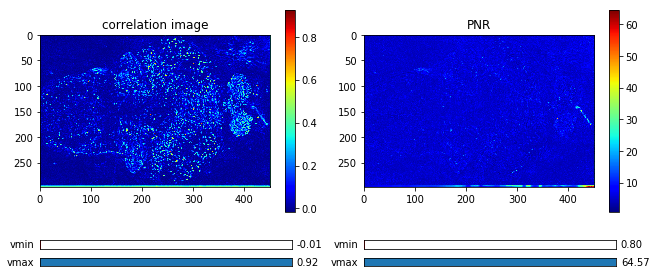

In [13]:
# compute some summary images (correlation and peak to noise)
#-------------------------------------------------------------------------------
cn_filter, pnr = cm.summary_images.correlation_pnr(images, gSig=gSig[0], swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# inspect the summary images and set the parameters
inspect_correlation_pnr(cn_filter, pnr)

In [14]:
# Restart cluster to clean up memory
#-------------------------------------------------------------------------------
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

#===============================================================================
# Run the actual Segmentation
#===============================================================================
cnm = cnmf.CNMF(n_processes, params=opts, dview=dview, Ain=Ain)
cnm = cnm.fit(images)

(80, 80)
46.587740898132324
Transforming patches into full matrix
Skipped %d Empty Patch 0
Generating background
Generating background DONE
merging


/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/caiman/source_extraction/cnmf/map_reduce.py:407: RuntimeWarning: divide by zero encountered in true_divide
  (1. / mask, (np.arange(d), np.arange(d))), dtype=np.float32)
/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


[178 179]
[ 97 161]
[173 183]


/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/caiman/source_extraction/cnmf/deconvolution.py:991: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]
/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:202: RuntimeWarning: invalid value encountered in greater
  res = self._with_data(op(self.data, other), copy=True)


No neurons merged!


ValueError: operands could not be broadcast together with shapes (229,3992) (230,3992) 

In [48]:
# Plot contours of found components
#-------------------------------------------------------------------------------
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
cnm.estimates.plot_contours_nb(img=Cn)

(3992, 298, 451)

In [19]:
#%% COMPONENT EVALUATION
#-------------------------------------------------------------------------------
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier - this doesn't currently work in this implementation

min_SNR = 3            # adaptive way to set threshold on the transient size
r_values_min = 0.85    # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': r_values_min,
                           'use_cnn': False})
cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

print(' ***** ')
print('Number of total components: ', len(cnm.estimates.C))
print('Number of accepted components: ', len(cnm.estimates.idx_components))

#%% PLOT COMPONENTS
#-------------------------------------------------------------------------------
cnm.estimates.plot_contours_nb(img=Cn, idx=cnm.estimates.idx_components)



/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/caiman/components_evaluation.py:704: RuntimeWarning: invalid value encountered in greater_equal
  idx_components_r = np.where(np.array(r_values) >= r_values_min)[0]     # threshold on space consistency
/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/caiman/components_evaluation.py:556: RuntimeWarning: invalid value encountered in greater_equal
  idx_components_r = np.where(r_values >= r_values_min)[0]
/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/caiman/components_evaluation.py:580: RuntimeWarning: invalid value encountered in less_equal
  bad_comps = np.where((r_values <= r_values_lowest) | (


 ***** 
Number of total components:  31
Number of accepted components:  4
